Posterior Mean of a (slope): 1.8284571365324638
Posterior Mean of b (intercept): 334.1269869445382
Posterior Covariance Matrix:
 [[ 1.38240460e-05 -2.88000909e-04]
 [-2.88000909e-04  8.00001754e-03]]


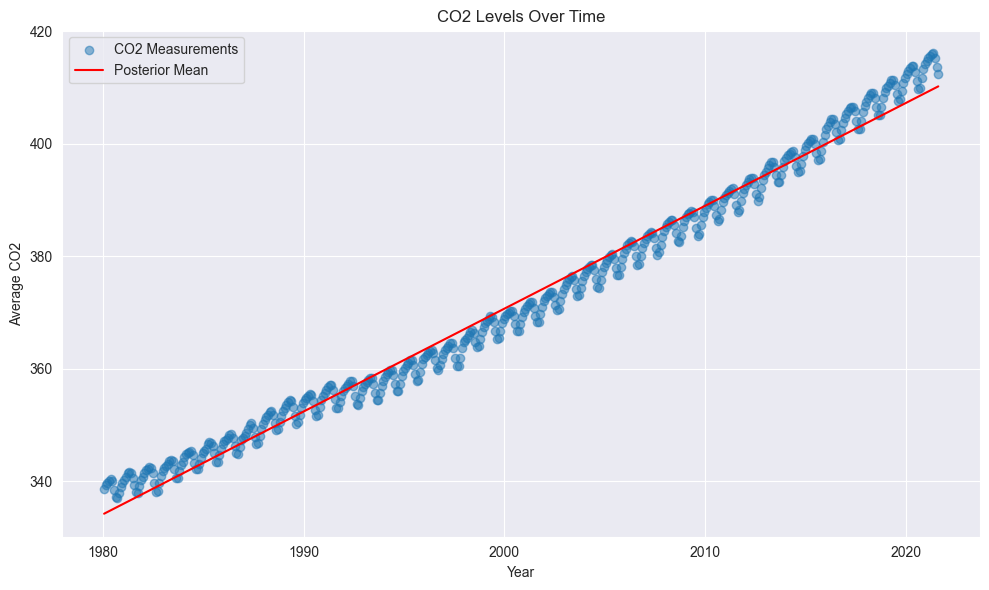

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
DATA_FILE = 'co2.txt'
BASE_YEAR = 1980.0  # Base year for adjusting the time variable

# Prior Parameters
PRIOR_MEAN = np.array([0.0, 360.0])  # [a, b]
PRIOR_COVARIANCE = np.diag([10.0**2, 100.0**2])  # Covariance matrix
PRIOR_COV_INV = np.linalg.inv(PRIOR_COVARIANCE)

# Initialize lists to store time and CO2 measurements
time = []
co2_average = []

# Load data from the file
try:
    with open(DATA_FILE, 'r') as file:
        for line in file:
            line = line.strip()

            # Skip comment lines and empty lines
            if line.startswith('#') or not line:
                continue

            # Split the line into columns
            columns = line.split()

            # Ensure there are at least 5 columns
            if len(columns) >= 5:
                try:
                    decimal_year = float(columns[2])
                    average_co2 = float(columns[3])

                    # Adjust time relative to the base year
                    adjusted_time = decimal_year - BASE_YEAR
                    time.append(adjusted_time)
                    co2_average.append(average_co2)
                except ValueError:
                    # Handle lines with non-numeric data
                    continue
except FileNotFoundError:
    raise FileNotFoundError(f"The file {DATA_FILE} was not found.")

# Convert lists to NumPy arrays for efficient computations
t = np.array(time)  # Time variable (years since BASE_YEAR)
y = np.array(co2_average)  # Average CO2 measurements

# Design Matrix Construction
# Each row corresponds to [t_i, 1] representing the linear model coefficients
X = np.column_stack((t, np.ones_like(t)))

# Posterior Covariance Calculation
# Σ_post = (Σ_prior^{-1} + X^T X)^{-1}
posterior_cov_inv = PRIOR_COV_INV + X.T @ X
posterior_covariance = np.linalg.inv(posterior_cov_inv)

# Posterior Mean Calculation
# μ_post = Σ_post (Σ_prior^{-1} μ_prior + X^T y)
posterior_mean = posterior_covariance @ (PRIOR_COV_INV @ PRIOR_MEAN + X.T @ y)

# Extract posterior estimates for parameters a and b
a_posterior, b_posterior = posterior_mean

# Display the results
print("Posterior Mean of a (slope):", a_posterior)
print("Posterior Mean of b (intercept):", b_posterior)
print("Posterior Covariance Matrix:\n", posterior_covariance)

# Optional: Visualization of the Data and Posterior Mean Line
plt.figure(figsize=(10, 6))
plt.scatter(t + BASE_YEAR, y, label='CO2 Measurements', alpha=0.5)
plt.plot(t + BASE_YEAR, a_posterior * t + b_posterior, color='red', label='Posterior Mean')
plt.xlabel('Year')
plt.ylabel('Average CO2')
plt.title('CO2 Levels Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


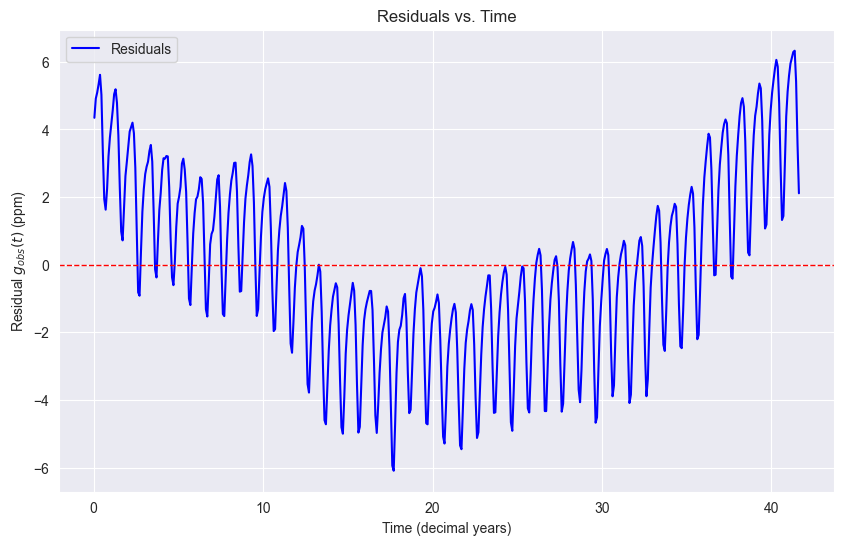

Mean of residuals: -0.0000
Variance of residuals: 7.1881
Shapiro-Wilk test statistic: 0.9891, p-value: 0.0009


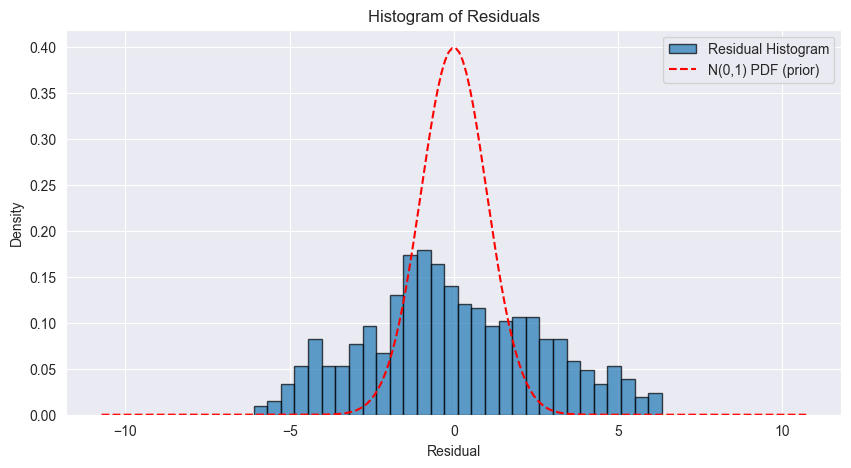

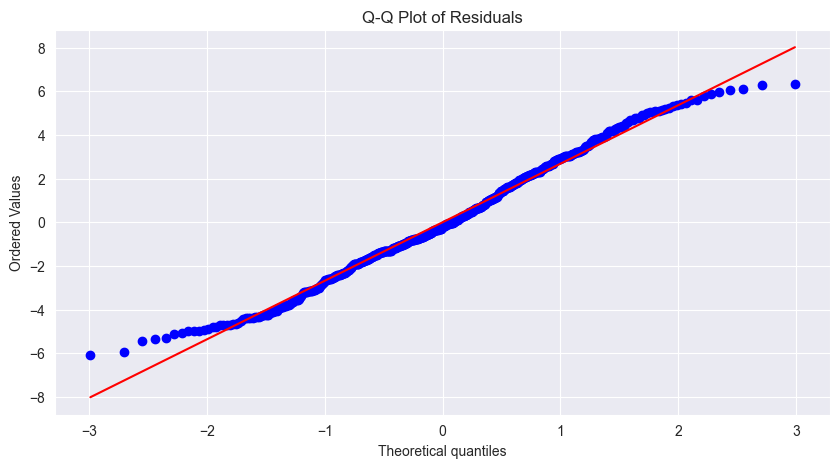

In [2]:
import scipy.stats as stats

# Assumptions for previous code:
# t: numpy array of shape (N,) containing times (decimal years)
# y: numpy array of shape (N,) containing observed CO2 concentrations (fobs(t))
# a_posterior, b_posterior: scalars for MAP estimates of a and b, obtained from previous steps

# Compute residuals: gobs(t) = fobs(t) - (a_MAP * t + b_MAP)
gobs = y - (a_posterior * t + b_posterior)

# Plot residuals against time as a line plot
plt.figure(figsize=(10, 6))
plt.plot(t, gobs, label='Residuals', color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Time (decimal years)')
plt.ylabel('Residual $g_{obs}(t)$ (ppm)')
plt.title('Residuals vs. Time')
plt.legend()
plt.grid(True)
plt.savefig(fname="2b1.png", dpi=300)
plt.show()

# Print mean and variance of residuals
mean_res = np.mean(gobs)
var_res = np.var(gobs, ddof=1)  # sample variance
print(f"Mean of residuals: {mean_res:.4f}")
print(f"Variance of residuals: {var_res:.4f}")

# Test normality (e.g., Shapiro-Wilk test)
shapiro_stat, shapiro_p = stats.shapiro(gobs)
print(f"Shapiro-Wilk test statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")

# Plot histogram of residuals and compare to a standard normal PDF
plt.figure(figsize=(10, 5))
plt.hist(gobs, bins=30, density=True, alpha=0.7, edgecolor='black', label='Residual Histogram')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')

# Plot a standard normal PDF to reflect the prior belief ε(t) ~ N(0,1)
xvals = np.linspace(mean_res - 4*np.sqrt(var_res), mean_res + 4*np.sqrt(var_res), 200)
normal_pdf = stats.norm.pdf(xvals, loc=0, scale=1)  # N(0,1)
plt.plot(xvals, normal_pdf, 'r--', label='N(0,1) PDF (prior)')
plt.legend()
plt.grid(True)
plt.savefig(fname="2b2.png", dpi=300)
plt.show()

# Q-Q plot to check normality
plt.figure(figsize=(10,5))
stats.probplot(gobs, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.savefig(fname="2b3.png", dpi=300)
plt.show()


In [4]:
import numpy as np

def sample_gp(x, cov_func):
    """
    Generate samples from a Gaussian Process with zero mean and given covariance function.

    :param x: numpy array of shape (N,) input points
    :param cov_func: a callable function k(s, t) that returns the covariance between s and t
    :return: f_sample: a numpy array of shape (N,) representing one sample from the GP at points x
    """
    # Construct covariance matrix K
    N = len(x)
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = cov_func(x[i], x[j])

    # Add a small jitter for numerical stability (if needed)
    K += 1e-10 * np.eye(N)

    # Draw a sample from N(0, K)
    f_sample = np.random.multivariate_normal(mean=np.zeros(N), cov=K)
    return f_sample


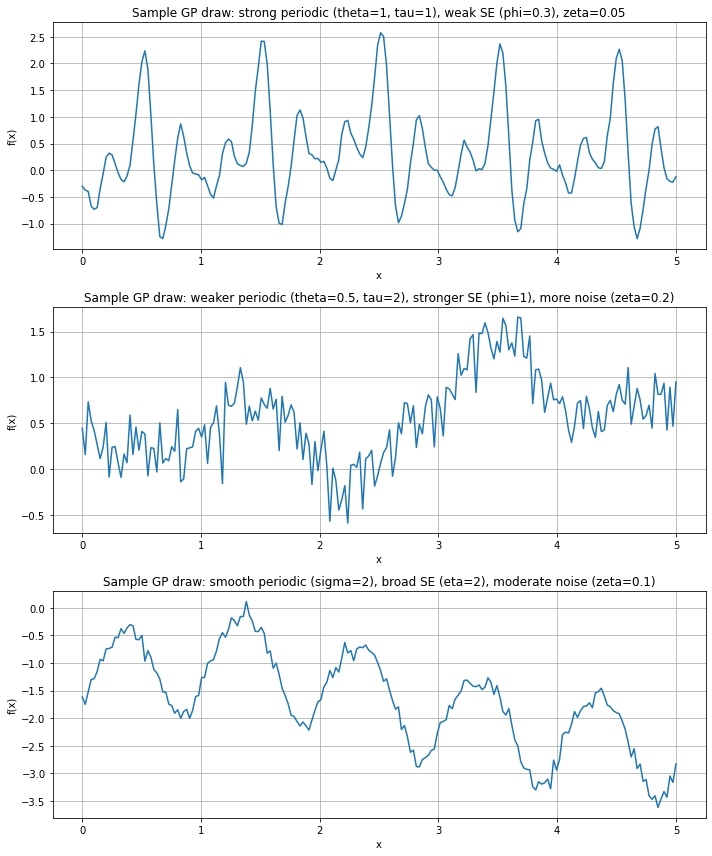

In [5]:
import matplotlib.pyplot as plt

def kernel(s, t, theta=1.0, tau=1.0, sigma=0.5, phi=1.0, eta=1.0, zeta=0.1):
    # Periodic part
    dist = np.pi * (s - t) / tau
    periodic_part = theta**2 * np.exp(-2 * (np.sin(dist)**2) / sigma**2)

    # SE part
    se_part = phi**2 * np.exp(-(s - t)**2 / (2 * eta**2))

    # Noise part (only when s == t)
    noise_part = zeta**2 if s == t else 0.0

    return periodic_part + se_part + noise_part

# Define input points
x = np.linspace(0, 5, 200)  # 200 points from 0 to 5

# Draw multiple samples for various parameters
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Example 1: Strong periodic component, small SE component
f_sample1 = sample_gp(x, lambda s, t: kernel(s, t, theta=1.0, tau=1.0, sigma=0.5, phi=0.3, eta=0.5, zeta=0.05))
axes[0].plot(x, f_sample1)
axes[0].set_title("Sample GP draw: strong periodic (theta=1, tau=1), weak SE (phi=0.3), zeta=0.05")

# Example 2: Weaker periodic component, stronger SE component, larger noise
f_sample2 = sample_gp(x, lambda s, t: kernel(s, t, theta=0.5, tau=2.0, sigma=1.0, phi=1.0, eta=1.0, zeta=0.2))
axes[1].plot(x, f_sample2)
axes[1].set_title("Sample GP draw: weaker periodic (theta=0.5, tau=2), stronger SE (phi=1), more noise (zeta=0.2)")

# Example 3: Very smooth periodic (large sigma) and broad SE (large eta)
f_sample3 = sample_gp(x, lambda s, t: kernel(s, t, theta=1.0, tau=1.0, sigma=2.0, phi=1.0, eta=2.0, zeta=0.1))
axes[2].plot(x, f_sample3)
axes[2].set_title("Sample GP draw: smooth periodic (sigma=2), broad SE (eta=2), moderate noise (zeta=0.1)")

for ax in axes:
    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.grid(True)

plt.tight_layout()
plt.show()


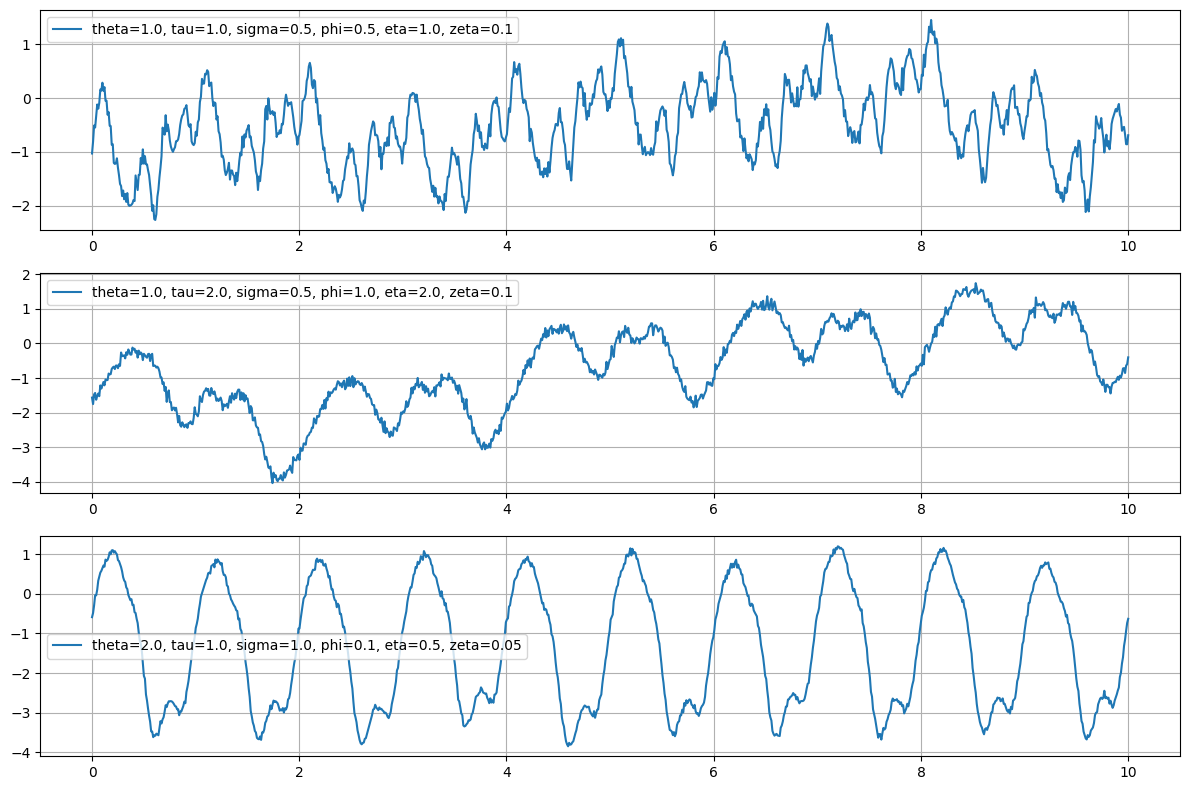

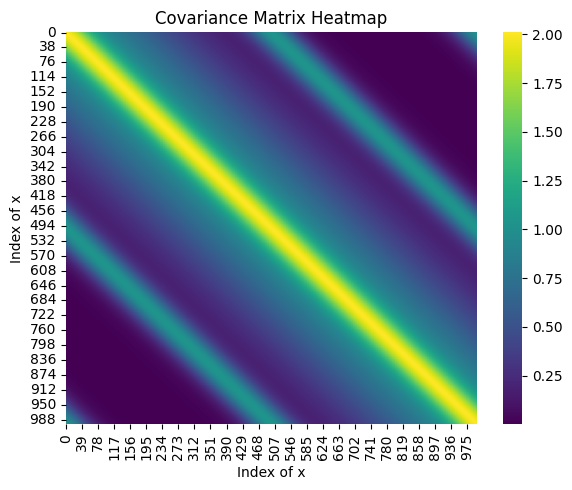

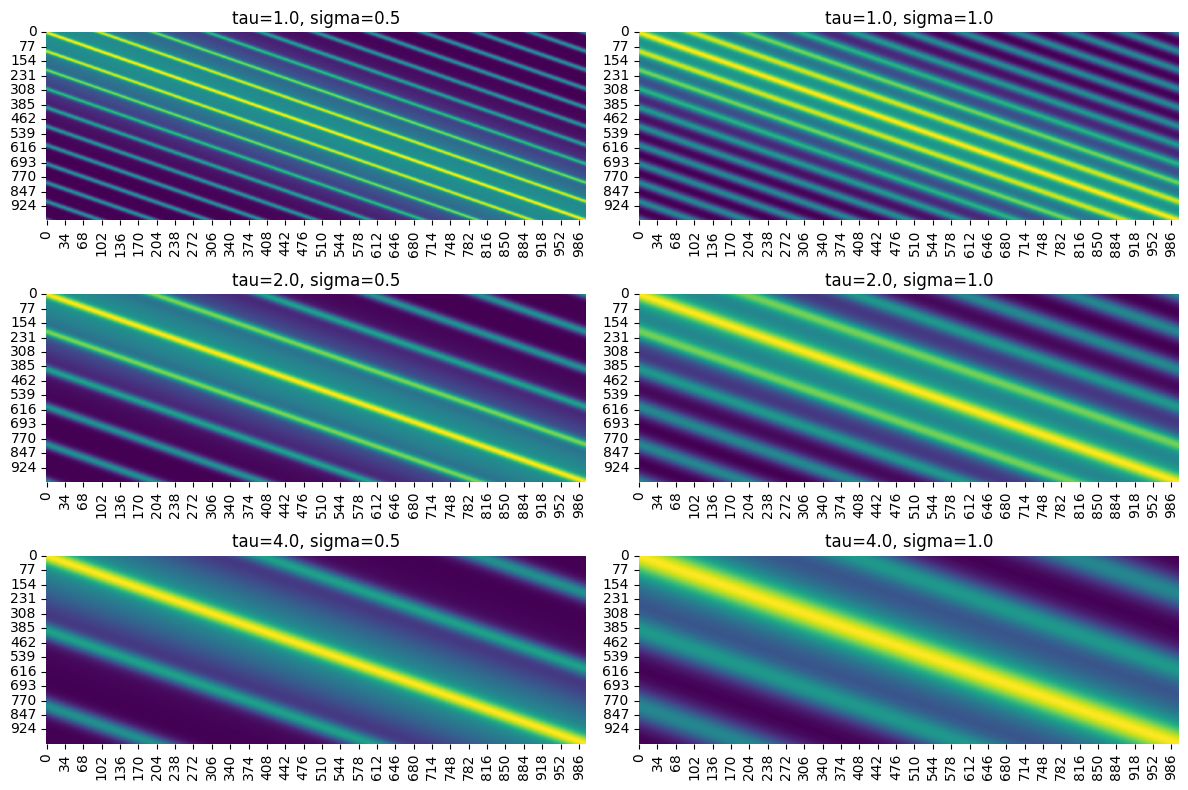

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def gp_sample(x, cov_func):
    """
    Draw a function sample f(x) from a GP with mean zero and covariance given by cov_func.

    Parameters:
    x : array-like of shape (N,)
        Input points at which to evaluate the GP sample.
    cov_func : callable
        A function k: (x, x) -> R that computes the covariance between two inputs.
        Should handle vectorized input for efficiency.

    Returns:
    f_sample : array of shape (N,)
        A single sample from the GP at points x.
    """
    # Compute covariance matrix K
    N = len(x)
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = cov_func(x[i], x[j])

    # To ensure numerical stability
    K += 1e-9 * np.eye(N)

    # Draw a random sample from N(0, K)
    f_sample = np.random.multivariate_normal(mean=np.zeros(N), cov=K)
    return f_sample, K


def periodic_rbf_kernel(s, t, theta=1.0, tau=1.0, sigma=1.0, phi=1.0, eta=1.0, zeta=0.1):
    # Periodic component
    periodic_part = theta**2 * np.exp(-2 * (np.sin(np.pi*(s-t)/tau)**2) / sigma**2)

    # RBF component
    rbf_part = (theta**2 * phi**2) * np.exp(-((s-t)**2) / (2*eta**2))

    # Noise component (added only when s == t)
    noise_part = zeta**2 if s == t else 0.0

    return periodic_part + rbf_part + noise_part
# Define input points
x = np.linspace(0, 10, 1000)  # for example from 0 to 10

# Example hyperparameters
param_sets = [
    {'theta':1.0, 'tau':1.0, 'sigma':0.5, 'phi':0.5, 'eta':1.0, 'zeta':0.1},
    {'theta':1.0, 'tau':2.0, 'sigma':0.5, 'phi':1.0, 'eta':2.0, 'zeta':0.1},
    {'theta':2.0, 'tau':1.0, 'sigma':1.0, 'phi':0.1, 'eta':0.5, 'zeta':0.05},
]

plt.figure(figsize=(12, 8))

for i, params in enumerate(param_sets, 1):
    def cov_func(si, ti):
        return periodic_rbf_kernel(si, ti, **params)

    f_sample, K = gp_sample(x, cov_func)
    plt.subplot(len(param_sets), 1, i)
    plt.plot(x, f_sample, label=f"theta={params['theta']}, tau={params['tau']}, sigma={params['sigma']}, phi={params['phi']}, eta={params['eta']}, zeta={params['zeta']}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


import seaborn as sns

# Choose a parameter set
params = {'theta':1, 'tau':5, 'sigma':0.5, 'phi':1.0, 'eta':2.0, 'zeta':0.1}

def cov_func(si, ti):
    return periodic_rbf_kernel(si, ti, **params)

# Compute K
N = len(x)
K = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        K[i,j] = cov_func(x[i], x[j])

plt.figure(figsize=(6,5))
sns.heatmap(K, cmap='viridis')
plt.title("Covariance Matrix Heatmap")
plt.xlabel('Index of x')
plt.ylabel('Index of x')
plt.tight_layout()
plt.savefig(fname = "gram.png", dpi = 300)
plt.show()
theta_values = [0.5, 1.0, 2.0]
tau_values = [1.0, 2.0, 4.0]
sigma_values = [0.5, 1.0]
phi_values = [0.5, 1.0]
eta_values = [0.5, 2.0]
zeta_values = [0.05, 0.1]

# Example: vary tau and sigma while fixing others
fig, axes = plt.subplots(len(tau_values), len(sigma_values), figsize=(12,8))
for i, tau_ in enumerate(tau_values):
    for j, sigma_ in enumerate(sigma_values):
        params = {'theta':1.0, 'tau':tau_, 'sigma':sigma_, 'phi':1.0, 'eta':2.0, 'zeta':0.1}
        def cov_func(si, ti):
            return periodic_rbf_kernel(si, ti, **params)
        K = np.zeros((N, N))
        for m in range(N):
            for n in range(N):
                K[m,n] = cov_func(x[m], x[n])
        ax = axes[i,j]
        sns.heatmap(K, cmap='viridis', ax=ax, cbar=False)
        ax.set_title(f"tau={tau_}, sigma={sigma_}")
plt.tight_layout()
plt.show()


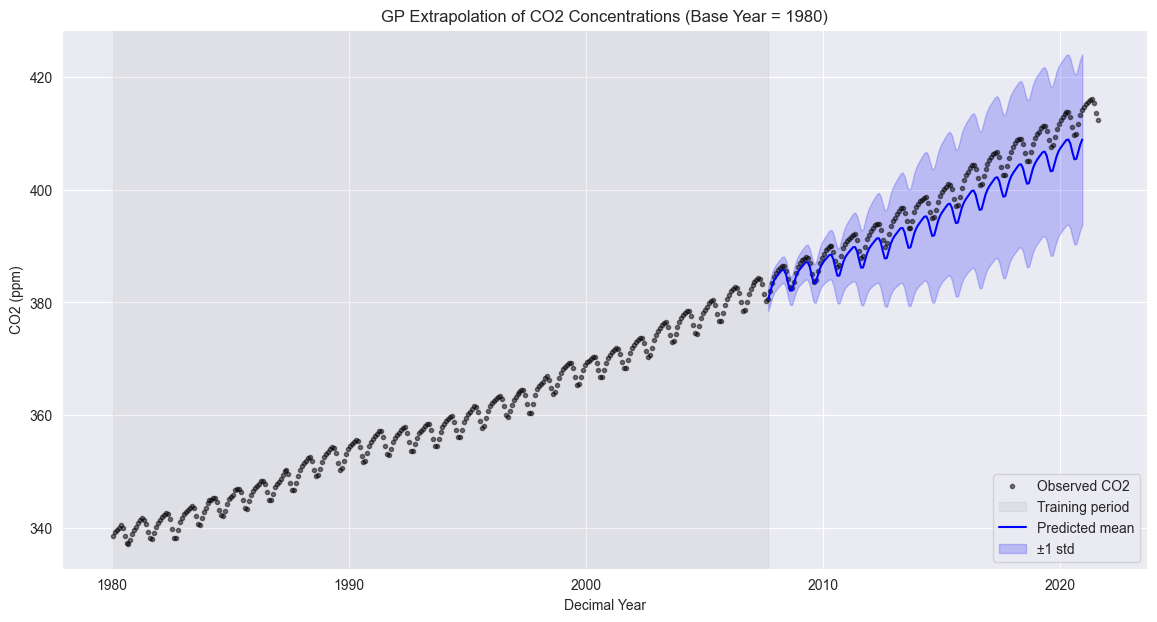

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.linalg import cho_factor, cho_solve
import numpy as np

# --- Step 1: Load CO2 data ---

t = []
y = []

# Load data from 'co2.txt'
with open('co2.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line.startswith('#') or len(line) == 0:
            continue
        parts = line.split()
        if len(parts) >= 5:
            decimal_year = float(parts[2])
            average_co2 = float(parts[3])
            # Shift base year to 1980
            decimal_year -= 1980.0
            t.append(decimal_year)
            y.append(average_co2)

# Convert to JAX arrays
t = jnp.array(t)
y = jnp.array(y)

# --- Step 2: Compute residuals g_obs(t) ---
g_obs = y - (a_posterior * t + b_posterior)

# --- Step 3: Define training and testing sets ---
cutoff = 2007.708 - 1980.0  # 27.708

train_idx = t <= cutoff
test_start = cutoff  # 27.708
test_end = 2020.958 - 1980.0  # 40.958

# Generate monthly intervals from test_start to test_end
num_months = int(round((test_end - test_start) * 12)) + 1  # +1 to include the end
test_t = jnp.linspace(test_start, test_end, num_months)

# Split training data
t_train = t[train_idx]
g_train = g_obs[train_idx]

# --- Step 4: Define the kernel function ---
def kernel(x1, x2, theta, tau, sigma, phi, eta, zeta):
    dist = jnp.pi * (x1[:, None] - x2[None, :]) / tau
    periodic_part = theta**2 * jnp.exp(-2.0 * (jnp.sin(dist)**2) / sigma**2)
    se_part = (theta**2 * phi**2) * jnp.exp(-( (x1[:, None] - x2[None, :])**2 )/(2 * eta**2))

    # Check if x1 and x2 represent the same array
    # Ensure that shapes match and all elements are equal
    same_input = (x1.shape == x2.shape) and bool(jnp.all(x1 == x2))
    noise_part = zeta**2 * jnp.eye(len(x1)) if same_input else 0.0

    return periodic_part + se_part + noise_part

# --- Step 5: Define Hyperparameters ---
# These are fixed as per your requirement
# Choose hyperparameters (these are just examples):
theta = 5   # amplitude of periodic
tau = 1   # annual period
sigma = 0.1   # smoothness of periodic part
phi = 3   # amplitude of SE part
eta = 5     # length-scale of SE part
zeta = 2    # noise level

# --- Step 6: Construct Covariance Matrices ---
# Compute training covariance matrix K with noise
K = kernel(t_train, t_train, theta, tau, sigma, phi, eta, zeta)

# Compute cross-covariance matrix K_star between test and train
K_star = kernel(test_t, t_train, theta, tau, sigma, phi, eta, zeta)

# Compute test covariance matrix K_star_star without noise
K_star_star = kernel(test_t, test_t, theta, tau, sigma, phi, eta, zeta)

# --- Step 7: Compute Inverse of K ---
# Perform Cholesky decomposition for numerical stability
L = jnp.linalg.cholesky(K)
# Compute K_inv using Cholesky factors
K_inv = cho_solve((L, True), jnp.eye(len(t_train)))

# --- Step 8: Predictive Mean and Covariance ---
# Predictive mean
g_mean = jnp.dot(K_star, jnp.dot(K_inv, g_train))

# Predictive covariance
# Compute v = L^{-1} K_star^T
v = cho_solve((L, True), K_star.T)
# Compute covariance matrix
g_cov = K_star_star - jnp.dot(K_star, v)
# Standard deviation
g_std = jnp.sqrt(jnp.diag(g_cov))

# --- Step 9: Compute Full CO2 Predictions ---
f_pred = a_posterior * test_t + b_posterior + g_mean

# --- Step 10: Plotting ---
plt.figure(figsize=(14, 7))
plt.plot(t + 1980.0, y, 'k.', alpha=0.5, label='Observed CO2')
plt.axvspan(1980.0, 1980.0 + cutoff, color='gray', alpha=0.1, label='Training period')
plt.plot(test_t + 1980.0, f_pred, 'b-', label='Predicted mean')
plt.fill_between(test_t + 1980.0, f_pred - g_std, f_pred + g_std, color='blue', alpha=0.2, label='±1 std')

plt.title('GP Extrapolation of CO2 Concentrations (Base Year = 1980)')
plt.xlabel('Decimal Year')
plt.ylabel('CO2 (ppm)')
plt.grid(True)
plt.legend()
plt.savefig("extrapolation_jax.png", dpi=300)
plt.show()


Optimizing hyperparameters:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration 0, NLL=463.1825866699219
Iteration 20, NLL=311.6171569824219
Iteration 40, NLL=256.51776123046875
Iteration 60, NLL=211.9947509765625
Iteration 80, NLL=178.25547790527344
Iteration 100, NLL=131.74191284179688
Iteration 120, NLL=91.15658569335938
Iteration 140, NLL=59.58131408691406
Iteration 160, NLL=33.600128173828125
Iteration 180, NLL=20.70989990234375
Optimized Hyperparameters:
theta = 1.6117096 tau = 0.99917936 sigma = 1.3915522 phi = 1.0819076 eta = 1.2200904 zeta = 0.20078409


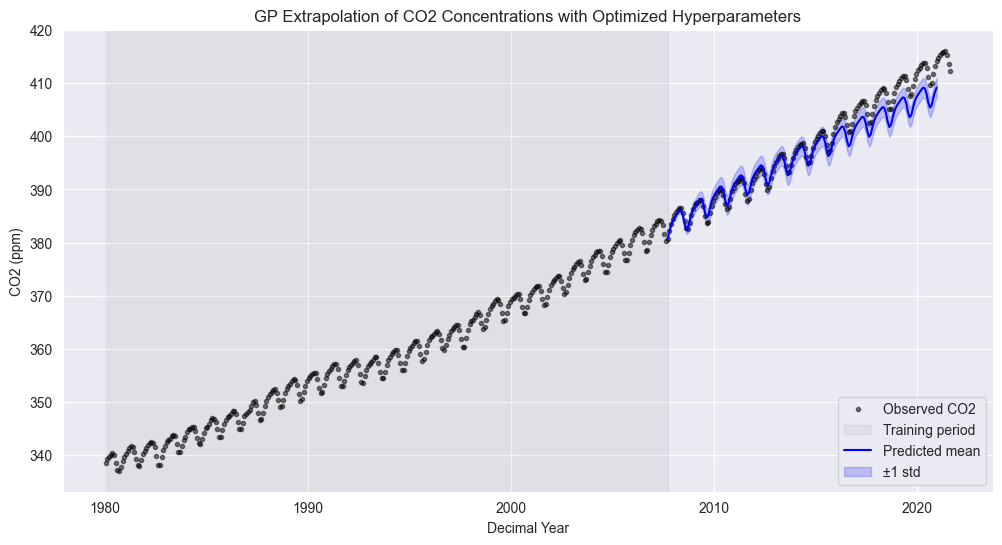

In [4]:
import jax
import jax.numpy as jnp
import optax
from tqdm.auto import trange

# --- Step 1: Load CO2 data (same as before, using base year 1980) ---
t = []
y = []
with open('co2.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line.startswith('#') or len(line) == 0:
            continue
        parts = line.split()
        if len(parts) >= 5:
            decimal_year = float(parts[2])
            average_co2 = float(parts[3])
            # Shift base year to 1980
            decimal_year -= 1980.0
            t.append(decimal_year)
            y.append(average_co2)

t = jnp.array(t)
y = jnp.array(y)


g_obs = y - (a_posterior * t + b_posterior)

# Training cutoff at 2007.708 => 27.708 after 1980
cutoff = 2007.708 - 1980.0
train_idx = t <= cutoff
t_train = t[train_idx]
g_train = g_obs[train_idx]


# --- Step 2: Define the kernel function ---
def kernel(x1, x2, theta, tau, sigma, phi, eta, zeta):
    dist = jnp.pi * (x1[:, None] - x2[None, :]) / tau
    periodic_part = theta**2 * jnp.exp(-2.0 * (jnp.sin(dist)**2) / sigma**2)
    se_part = (theta**2 * phi**2) * jnp.exp(-( (x1[:, None] - x2[None, :])**2 )/(2 * eta**2))

    # Check if x1 and x2 represent the same array
    # Ensure that shapes match and all elements are equal
    same_input = (x1.shape == x2.shape) and bool(jnp.all(x1 == x2))
    noise_part = zeta**2 * jnp.eye(len(x1)) if same_input else 0.0

    return periodic_part + se_part + noise_part

# --- Step 3: Negative log-likelihood ---
def neg_log_marginal_likelihood(params, X, y):
    # params is a dictionary of raw parameters in log-space
    # Exponentiate to ensure positivity
    theta = jnp.exp(params['log_theta'])
    sigma = jnp.exp(params['log_sigma'])
    phi = jnp.exp(params['log_phi'])
    eta = jnp.exp(params['log_eta'])
    zeta = jnp.exp(params['log_zeta'])
    tau = jnp.exp(params['log_tau'])
    # Construct K
    K = kernel(X, X, theta, tau, sigma, phi, eta, zeta)
    # Add a small jitter for numerical stability
    K += 1e-10 * jnp.eye(len(X))

    # Compute NLL = 0.5*y^T K^-1 y + 0.5 log|K| + n/2 log(2π)
    L = jnp.linalg.cholesky(K)
    # Solve for alpha = K^-1 y using Cholesky
    alpha = jax.scipy.linalg.cho_solve((L, True), y)
    n = len(X)
    nll = 0.5 * y.dot(alpha) + jnp.sum(jnp.log(jnp.diag(L))) + 0.5 * n * jnp.log(2.0 * jnp.pi)
    return nll

# --- Step 4: Setup Optimization ---
# Initial guesses for parameters in log-space
init_params = {
    'log_theta': jnp.log(1.0),
    'log_sigma': jnp.log(1.0),
    'log_phi': jnp.log(1.0),
    'log_eta': jnp.log(5.0),
    'log_zeta': jnp.log(1.0),
    'log_tau': jnp.log(1.0)
}

# Use Adam optimizer from optax
learning_rate = 0.01
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(init_params)

# We can jit the gradient function for efficiency
grad_fn = jax.grad(neg_log_marginal_likelihood)

# --- Step 5: Run Gradient-Based Optimization ---
num_iters = 200
params = init_params
for i in trange(num_iters, desc="Optimizing hyperparameters"):
    grads = grad_fn(params, t_train, g_train)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if i % 20 == 0:
        current_loss = neg_log_marginal_likelihood(params, t_train, g_train)
        print(f"Iteration {i}, NLL={current_loss}")

# After optimization
opt_theta = jnp.exp(params['log_theta'])
opt_sigma = jnp.exp(params['log_sigma'])
opt_phi = jnp.exp(params['log_phi'])
opt_eta = jnp.exp(params['log_eta'])
opt_zeta = jnp.exp(params['log_zeta'])
opt_tau = jnp.exp(params['log_tau'])

print("Optimized Hyperparameters:")
print("theta =", opt_theta, "tau =", opt_tau, "sigma =", opt_sigma, "phi =", opt_phi, "eta =", opt_eta, "zeta =", opt_zeta)

# --- Step 6: Make Predictions ---
# Suppose we want to predict beyond cutoff
test_start = 2007.708 - 1980.0
test_end = 2020.958 - 1980.0
num_months = int(round((test_end - test_start) * 12)) + 1
test_t = jnp.linspace(test_start, test_end, num_months)

K = kernel(t_train, t_train, opt_theta, opt_tau, opt_sigma, opt_phi, opt_eta, opt_zeta)
K_star = kernel(test_t, t_train, opt_theta, opt_tau, opt_sigma, opt_phi, opt_eta, opt_zeta)
K_star_star = kernel(test_t, test_t, opt_theta, opt_tau, opt_sigma, opt_phi, opt_eta, opt_zeta)

K_inv = jnp.linalg.inv(K)
g_mean = K_star @ K_inv @ g_train
g_cov = K_star_star - K_star @ K_inv @ K_star.T
g_std = jnp.sqrt(jnp.diag(g_cov))

f_pred = a_posterior * test_t + b_posterior + g_mean

# --- Step 7: Plot Results ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(t + 1980.0, y, 'k.', alpha=0.5, label='Observed CO2')
plt.axvspan(1980.0, 1980.0 + cutoff, color='gray', alpha=0.1, label='Training period')
plt.plot(test_t + 1980.0, f_pred, 'b-', label='Predicted mean')
plt.fill_between(test_t + 1980.0, f_pred - g_std, f_pred + g_std, color='blue', alpha=0.2, label='±1 std')

plt.title('GP Extrapolation of CO2 Concentrations with Optimized Hyperparameters')
plt.xlabel('Decimal Year')
plt.ylabel('CO2 (ppm)')
plt.grid(True)
plt.legend()
plt.savefig("extrapolation_optimized.png", dpi=300)
plt.show()
